# Load MR images in Colab

In [1]:
# importing libraries 
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [ ]:
!pip install tensorflow-wavelets
import tensorflow_wavelets.Layers.DWT as DWT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mixed precision policy

In order to make our models faster, we will use [TensorFlow mixed-precision](https://www.tensorflow.org/guide/mixed_precision).

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Data pipeline

We will use a data pipeline very similar to the one defined in practical 3. We simply need to modify our Python generator in order to adapt it to residual learning. For that, it must yield the 3T MR image and the residual (7T-3T image) instead of the 3T and 7T image.

## Python generator

In [ ]:
# new generator 
f_3T_name = '/content/drive/MyDrive/G4/MLSP/project/final_data/3T_images'
f_7T_name = '/content/drive/MyDrive/G4/MLSP/project/final_data/7T_images'

list_3T = [name for name in os.listdir(f_3T_name)]
list_7T = [name for name in os.listdir(f_7T_name)]

def generator(exclude=-1):
  for i, filename in enumerate(list_3T):
    if i != exclude:
      img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
      img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()

      # convert to tensors
      img_3T = tf.convert_to_tensor(img_3T, dtype=tf.float32)
      img_7T = tf.convert_to_tensor(img_7T, dtype=tf.float32)
      yield img_3T, tf.subtract(img_7T, img_3T)

generator()

<generator object generator at 0x7f678a02d0b0>

## Patch extraction

In [ ]:
def patch_extraction(tf_3T, tf_7T, nb_exc_slices=30):
  idx = tf.random.uniform(shape=(2,), dtype=tf.int32, maxval=3000000)
  return tf.image.stateless_random_crop(tf_3T[:, :, nb_exc_slices: -nb_exc_slices], [64, 64, 3], seed=idx), tf.image.stateless_random_crop(tf_7T[:, :, nb_exc_slices: -nb_exc_slices], [64, 64, 3], seed=idx)

## Tensorflow dataset

In [ ]:
def training_dataset(exclude=-1):
  dataset = tf.data.Dataset.from_generator(generator, args=(exclude,), output_signature=(
      tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32), 
      tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32)
    ))
  dataset = dataset.cache()
  if exclude == -1:
    dataset = dataset.shuffle(10)
  else:
    dataset = dataset.shuffle(9)
  dataset = dataset.repeat(40)
  dataset = dataset.map(patch_extraction, tf.data.AUTOTUNE)
  dataset = dataset.batch(32)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset


# Model architecture

We will here implement the main ideas described in the [reference paper](https://www-sciencedirect-com.ressources-electroniques.univ-lille.fr/science/article/pii/S1361841520300293), i.e. the residual learning, WAT layers and DBlocks. As these 3 elements imply complex architectures (multiple inputs, concatenations, skip connections...), we will use the [functional API](https://www.tensorflow.org/guide/keras/functional).

Notes:
  - the filter weights in the convolutional layers are initialized with the *HeNormal* initializer.
  - most of the convolutional layers are followed by a relu activation

## WAT layer

Define a function that implements a WAT layer as described in the paper. This function returns a keras model that will itself be used in the main model (you can define it as a keras layer if you prefer).

The returned *keras.Model* instance will take 2 inputs:
  - feature maps from previous layer $\rightarrow$ shape `(None,None,64)`
  - wavelet detail coefficients $\rightarrow$ shape `(None,None,9)` (3 coefficients * 3 axial slices)

As described in the section 3.2 of the article, this block applies 2 * 2 convolutions on the wavelet coefficients in order to compute the affine parameters $\gamma$ et $\beta$ that will be used to perform element-wise multiplication and addition on the feature maps from the previous layer.

In [ ]:
def wat_layer():
  """ returns a keras model corresponding to the WAT layer"""
  feature_maps = keras.Input(shape=(None, None, 64), name='feature maps')
  wavelet_details = keras.Input(shape=(None, None, 9), name='wavelet details')
  gamma = layers.Conv2D(filters=64, kernel_size=2, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(wavelet_details)
  beta = layers.Conv2D(filters=64, kernel_size=2, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(wavelet_details)

  outputs = layers.Multiply()([feature_maps, gamma])
  outputs = layers.Add()([outputs, beta])

  model = keras.Model(inputs=[feature_maps, wavelet_details], outputs=outputs)
  return model


Plot a WAT layer with `keras.plot_model`.

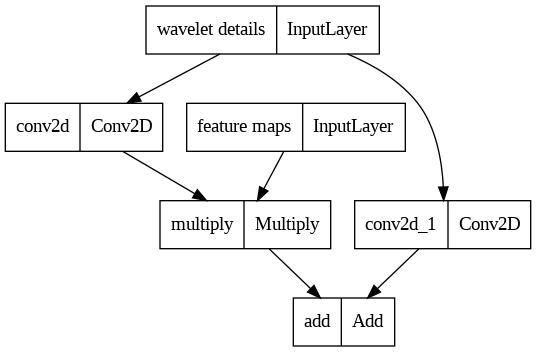

In [ ]:
model = wat_layer()
keras.utils.plot_model(model)

## DBlock

Similarly, define a function that implements a DBlock as described in the paper (Figure 4). The returned *keras.Model* instance will take the feature maps from the previous layer as input (shape `(None,None,64)`).

DBlocks are composed of 2 parts: the enhancement unit and the depression unit. The enhancement unit comprises 6 convolutions that are compiled in a short path and a long path. Slicing operations split intermediate feature maps into 16 and 48 channels for the short and the long path, respectively ([Lambda layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) and [Tensor slicing](https://www.tensorflow.org/guide/tensor_slicing) can be useful). A concatenation operation is also used to combine input and intermediate feature maps.

There are 3 different types of depression unit:
  - *downsampling* $\rightarrow$ A convolution with stride $2^2$ that downsamples the feature maps
  - *upsamling* $\rightarrow$ A convolution with stride $1^2$ followed by a transposed convolution with stride $2^2$ that upsamples the feature maps
  - *simple* $\rightarrow$ A convolution with stride $1^2$.

Your function can take an argument that sets the type of depression unit in the returned DBlock.

In [ ]:
def dblock_layer(type="downsampling"):
  """ return a keras model corresponding to the DBlock layer"""
  inputs = keras.Input(shape=(None, None, 64), name='last layer inputs')
  # enhancement layer
  x = layers.Conv2D(filters=48, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
  x = layers.Activation('ReLU', dtype='float32')(x)
  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x)
  x = layers.Activation('ReLU', dtype='float32')(x)
  x = layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x)
  x = layers.Activation('ReLU', dtype='float32')(x)

  split = layers.Lambda(lambda x: tf.split(x, num_or_size_splits=[16, 48], axis=-1))(x)
  x_short = split[0]
  x_long = split[1]

  #x_short = tf.slice(x, begin=[None, None, 0], size=[None, None, 16])
  #x_long = tf.slice(x, begin=[None, None, 16], size=[None, None, 48])

  x_short = layers.Concatenate(axis=-1)([inputs, x_short])

  x_long = layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_long)
  x_long = layers.Activation('ReLU', dtype='float32')(x_long)
  x_long = layers.Conv2D(filters=48, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_long)
  x_long = layers.Activation('ReLU', dtype='float32')(x_long)
  x_long = layers.Conv2D(filters=80, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_long)
  x_long = layers.Activation('ReLU', dtype='float32')(x_long)

  output_enh = layers.Add()([x_long, x_short])    # enhance output

  # depression layer
  if type == 'downsampling':
    output_dep = layers.Conv2D(filters=64, kernel_size=1, strides=(2,2), padding='valid', kernel_initializer=tf.keras.initializers.HeNormal())(output_enh)
    output_dep = layers.Activation('ReLU', dtype='float32')(output_dep)
  elif type == 'upsampling':
    output_dep = layers.Conv2D(filters=64, kernel_size=1, strides=(1,1), padding='valid', kernel_initializer=tf.keras.initializers.HeNormal())(output_enh)
    output_dep = layers.Activation('ReLU', dtype='float32')(output_dep)
    output_dep = layers.Conv2DTranspose(filters=64, kernel_size=1, strides=(2,2), kernel_initializer=tf.keras.initializers.HeNormal())(output_dep)

  elif type == 'simple':
    output_dep = layers.Conv2D(filters=64, kernel_size=1, strides=(1,1), padding='valid', kernel_initializer=tf.keras.initializers.HeNormal())(output_enh)
    output_dep = layers.Activation('ReLU', dtype='float32')(output_dep)
  else:
    raise Exception("Unrecognised type of depression unit! Choose one of the following: \n'downsampling'\t'upsamling'\t'simple'")

  model = keras.Model(inputs=inputs, outputs=output_dep)
  return model

Plot a DBlock with `keras.plot_model`.

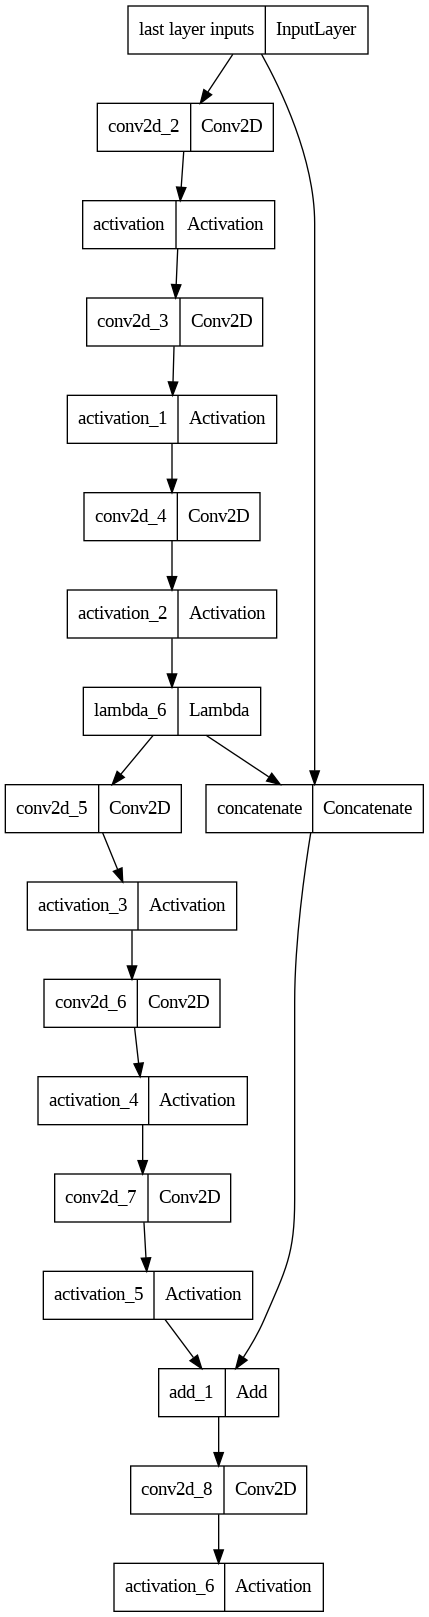

In [ ]:
model = dblock_layer()
keras.utils.plot_model(model)

## Global architecture

Define a function that implements a model as described in the article. The model combines WAT layers and DBlocks.

To compute the wavelet coefficients, you can use the **tensorflow-wavelets** package. More precisely, you can use layers `DWT(wavelet_name="haar", concat=0, dtype='float32')` to compute 4 wavelet coefficients from each input channel. 3 of them will be given to a WAT layer (the 3 precision coefficients) and the other will be used to compute recursively the next wavelet coefficients (again you can use tensor slicing).

The model is splitted in an extraction branch and a reconstruction branch. The extraction branch comprises 2 convolutions, 3 *downsampling* DBlocks (each one followed by a WAT layer) and a *simple* DBlock. The reconstruction branch comprises a *simple* DBlock, 3 *upsampling* DBlocks and 2 convolutions. The last convolution is followed by a *tanh* activation (`Activation('tanh', dtype='float32')`) as we want to estimate residuals.

In [ ]:
def watnet():
  """ returns the WAT model as described in the original paper """
  ### extraction branch ###
  inputs = keras.Input(shape=(None, None, 3))

  # wavelet branch
  wav1 = DWT.DWT(wavelet_name='haar', concat=0, dtype='float32')(inputs)
  approx1, details1 = layers.Lambda(lambda x: tf.split(x, num_or_size_splits=[wav1.shape[-1]//4, -1], axis=-1))(wav1)

  wav2 = DWT.DWT(wavelet_name='haar', concat=0, dtype='float32')(approx1)
  approx2, details2 = layers.Lambda(lambda x: tf.split(x, num_or_size_splits=[wav2.shape[-1]//4, -1], axis=-1))(wav2)

  wav3 = DWT.DWT(wavelet_name='haar', concat=0, dtype='float32')(approx2)
  approx3, details3 = layers.Lambda(lambda x: tf.split(x, num_or_size_splits=[wav3.shape[-1]//4, -1], axis=-1))(wav3)


  # downsampling branch 
  x1 = layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
  x1 = layers.Activation('ReLU', dtype='float32')(x1)
  x1 = layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x1)
  x1 = layers.Activation('ReLU', dtype='float32')(x1)

  dist1 = dblock_layer(type='downsampling')(x1)
  x2 = wat_layer()([dist1, details1])

  dist2 = dblock_layer(type='downsampling')(x2)
  x3 = wat_layer()([dist2, details2])

  dist3 = dblock_layer(type='downsampling')(x3)
  x4 = wat_layer()([dist3, details3])

  x5 = dblock_layer(type='simple')(x4)


  ### reconstruction branch ###

  resid = dblock_layer(type='simple')(x5)
  resid = dblock_layer(type='upsampling')(resid)
  resid = dblock_layer(type='upsampling')(resid)
  resid = dblock_layer(type='upsampling')(resid)


  resid = layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(resid)
  resid = layers.Activation('ReLU', dtype='float32')(resid)
  resid = layers.Conv2D(filters=3, kernel_size=3, strides=(1,1), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(resid)
  resid = layers.Activation('tanh', dtype='float32')(resid)


  #outputs = layers.Add()([inputs, resid])

  model = keras.Model(inputs=inputs, outputs=resid)

  return model

Plot your model architecture with `keras.plot_model`.

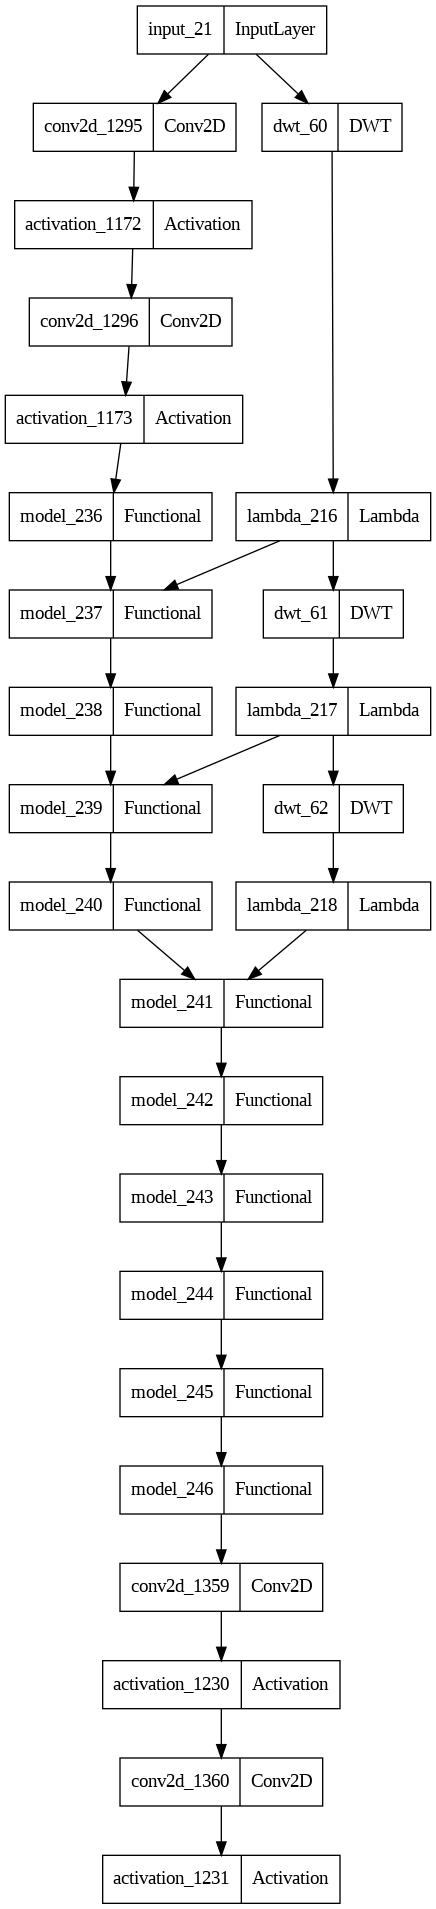

In [ ]:
model = watnet()
keras.utils.plot_model(model, show_shapes=False, to_file='/content/drive/MyDrive/G4/MLSP/project/watnet.png')

# Inference function

We will adapt the inference function we defined in practical 3. Firstly, the models now infer residuals (not directly images as before); we therefore need to add the inferred maps to the input 3T MRI in order to obtain the 7T image. Secondly, the introduction of downsampling and upsampling operations requires to have feature maps with width and height divisible by 2. Thus, the input patches must have width and height divisible by $2^3$ (3 *downsampling*/*upsampling* DBlocks), which is the case for `(64,64,3)` but not for `(182,218,3)`. A way to circumvent this issue is to zero-pad the patches before the inference.

In [ ]:
def inference(tf_3T, model, nb_exc_slices=30):
  outputs = [tf_3T[:, :, :nb_exc_slices]]

  for i in range(nb_exc_slices, (tf_3T.shape[2]-nb_exc_slices)//3*3, 3):
    x = tf.add(model(tf.expand_dims(tf_3T[:, :, i:i+3], axis=0))[0], tf_3T[:, :, i:i+3])
    outputs.append(x)
  
  slice_to_avg = 3 - (tf_3T.shape[2]-nb_exc_slices) % 3
  # add last 3 slices
  b_last = outputs.pop()
  last = tf.add(model(tf.expand_dims(tf_3T[:, :, -nb_exc_slices-3:-nb_exc_slices], axis=0))[0], tf_3T[:, :, -nb_exc_slices-3:-nb_exc_slices])
  #last = model(tf.expand_dims(tf_3T[:, :, -nb_exc_slices-3:-nb_exc_slices], axis=0))[0]
  avg_slice = tf.keras.layers.Average()([b_last[:, :, -slice_to_avg:], last[:, :, :slice_to_avg]])  # avgeraged slices

  outputs.append(b_last[:, :, :-slice_to_avg])
  outputs.append(tf.cast(avg_slice, dtype='float32'))
  outputs.append(last[:, :, -(3-slice_to_avg):])
  outputs.append(tf_3T[:, :, -nb_exc_slices:])

  return tf.concat(outputs, axis=2)

```python
def inference(tf_3T, model, nb_exc_slices=30):
  outputs = [tf_3T[:, :, :nb_exc_slices]]

  for i in range(nb_exc_slices, (tf_3T.shape[2]-nb_exc_slices)//3*3, 3):
    outputs.append(model(tf.expand_dims(tf_3T[:, :, i:i+3], axis=0))[0])
  
  slice_to_avg = 3 - (tf_3T.shape[2]-nb_exc_slices) % 3
  # add last 3 slices
  b_last = outputs.pop()
  last = model(tf.expand_dims(tf_3T[:, :, -nb_exc_slices-3:-nb_exc_slices], axis=0))[0]
  avg_slice = tf.keras.layers.Average()([b_last[:, :, -slice_to_avg:], last[:, :, :slice_to_avg]])  # avgeraged slices

  outputs.append(b_last[:, :, :-slice_to_avg])
  outputs.append(tf.cast(avg_slice, dtype='float32'))
  outputs.append(last[:, :, -(3-slice_to_avg):])
  outputs.append(tf_3T[:, :, -nb_exc_slices:])

  return tf.concat(outputs, axis=2)
```

# Training and evaluation

For this section, you should be able to reuse the same code as practical 3.

## Display function

In [ ]:
def display_slice_per_dimension(mr_img, slice_x=100, slice_y=100, slice_z=100):
  fig, ax = plt.subplots(1, 3, figsize=(3*5, 5))
  ax[0].imshow(mr_img[slice_x, :, :], cmap='gray')
  ax[1].imshow(mr_img[:, slice_y, :], cmap='gray')
  ax[2].imshow(mr_img[:, :, slice_z], cmap='gray')

  ax[0].set(title='slice along x')
  ax[1].set(title='slice along y')
  ax[2].set(title='slice along z')

  plt.show()
  

## Training configuration

In [ ]:
EPOCHS = 30
START_LR_RATE = 0.001
END_LR_RATE = 0.0001
DECAY_STEPS = 10
POWER = 1.   # linear learning rate decay

optim_schedules = tf.keras.optimizers.schedules.PolynomialDecay(
    START_LR_RATE,
    DECAY_STEPS,
    END_LR_RATE,
    power=POWER)

# define model 
model = watnet()

optimizer = tf.keras.optimizers.Adam(
                  learning_rate=optim_schedules)

model.compile(optimizer=optimizer,
              loss='mae', 
              run_eagerly=True)


## Execution

Epoch 1/10
12/12 [==============================] - 12s 825ms/step - loss: 0.0947
Epoch 2/10
12/12 [==============================] - 8s 526ms/step - loss: 0.0390
Epoch 3/10
12/12 [==============================] - 5s 395ms/step - loss: 0.0375
Epoch 4/10
12/12 [==============================] - 5s 393ms/step - loss: 0.0362
Epoch 5/10
12/12 [==============================] - 5s 391ms/step - loss: 0.0358
Epoch 6/10
12/12 [==============================] - 5s 397ms/step - loss: 0.0339
Epoch 7/10
12/12 [==============================] - 5s 397ms/step - loss: 0.0330
Epoch 8/10
12/12 [==============================] - 5s 388ms/step - loss: 0.0332
Epoch 9/10
12/12 [==============================] - 5s 383ms/step - loss: 0.0324
Epoch 10/10
12/12 [==============================] - 5s 387ms/step - loss: 0.0332
SSIM: 0.9580000042915344 | PNSR: 29.941999435424805 | MAE: 0.009999999776482582
Epoch 1/10
12/12 [==============================] - 7s 380ms/step - loss: 0.1151
Epoch 2/10
12/12 [=========

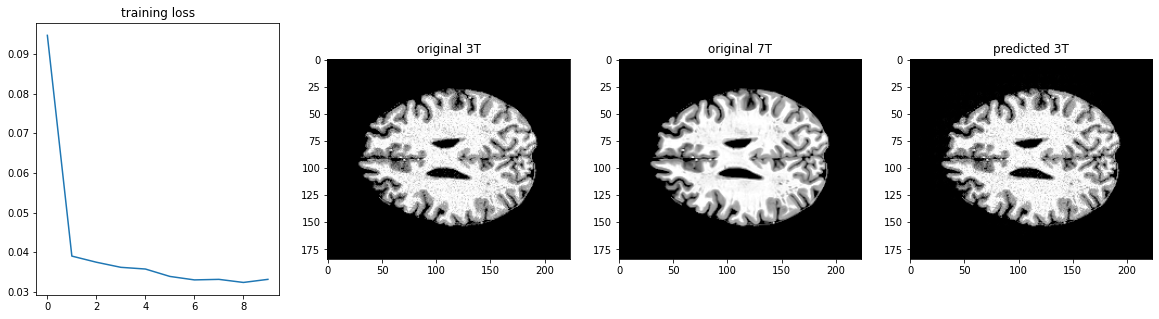

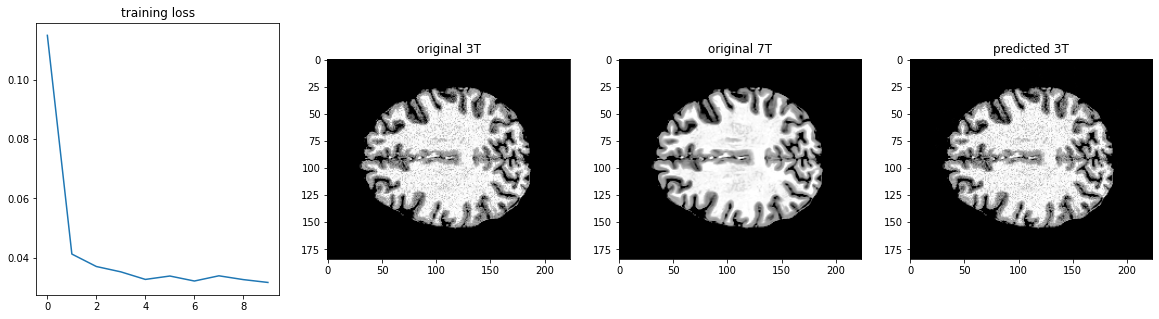

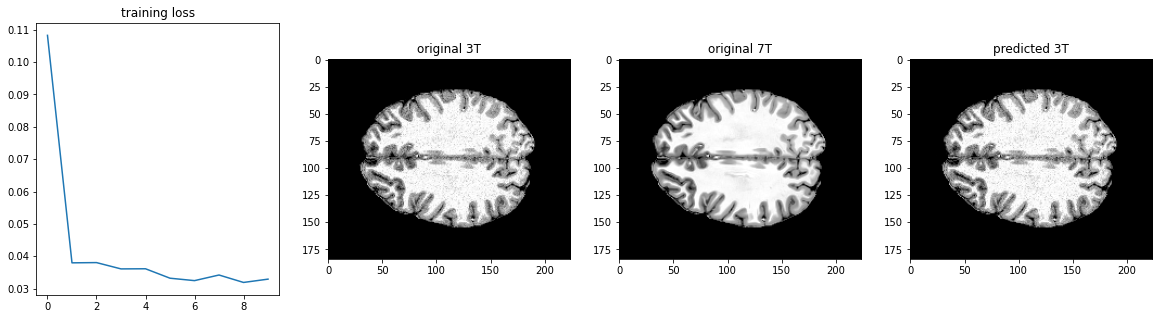

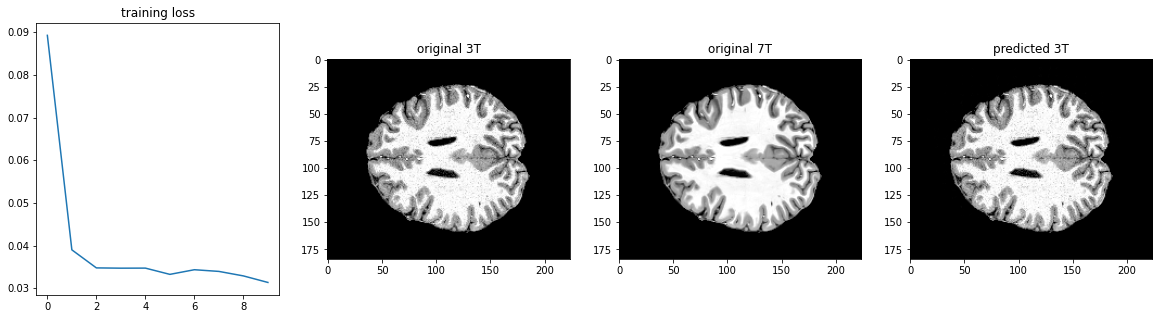

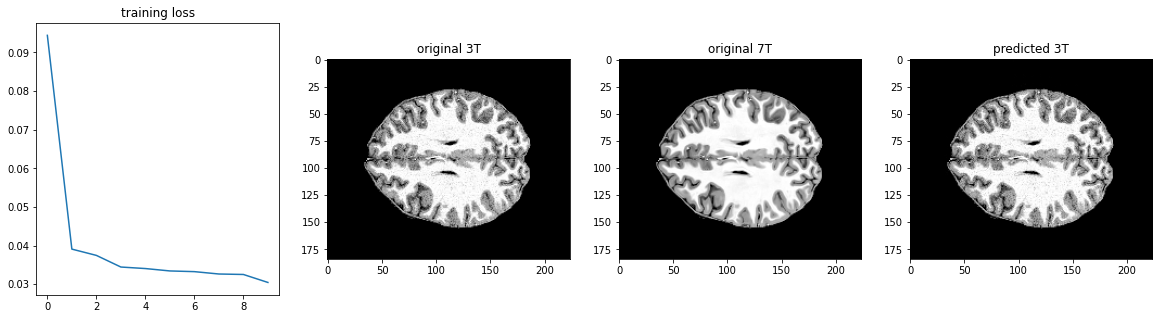

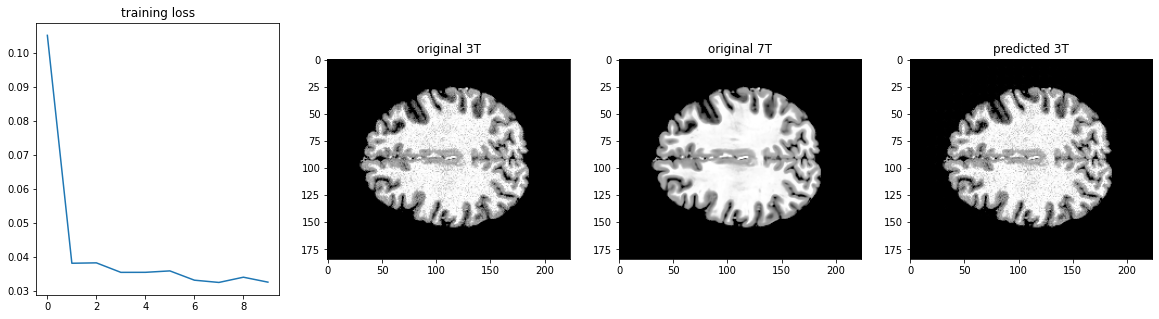

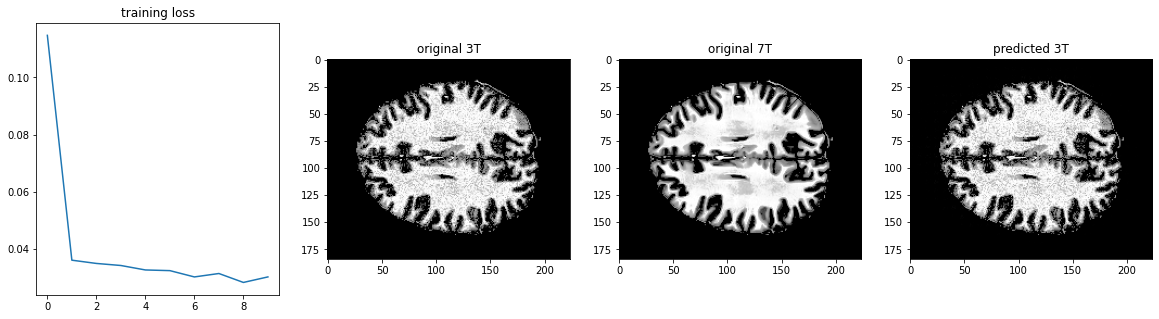

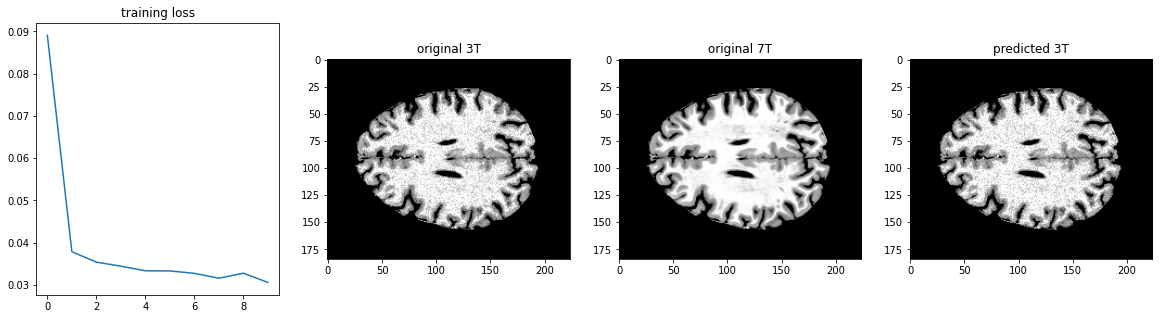

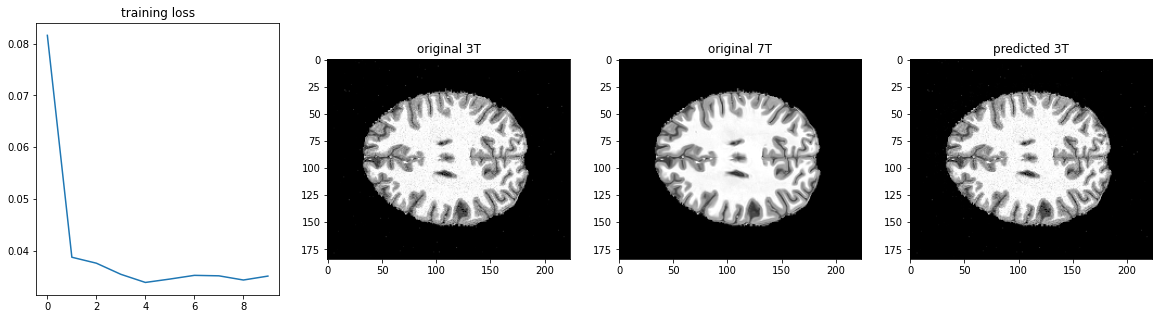

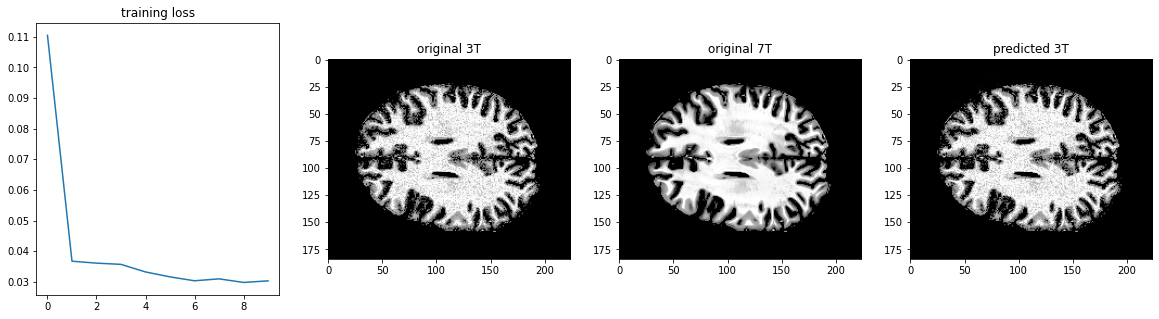

In [ ]:
# initialize tqdm callback with default parameters
ssim_list = []
psnr_list = []
mae_list = []
EPOCHS = 10
list_synth_7T = []

for i in range(10):
  model = watnet()
  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=optim_schedules)

  model.compile(optimizer=optimizer,
              loss='mae', 
              run_eagerly=True)
  
  # define dataset
  dataset = training_dataset(i)
  filename = list_3T[i]

  img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
  img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()
  img_3T_test = tf.convert_to_tensor(img_3T, dtype=tf.float32)
  img_7T_test = tf.convert_to_tensor(img_7T, dtype=tf.float32)

  img_3T_test = tf.pad(img_3T_test, tf.constant([[1, 1,], [3, 3], [0, 0]]), "CONSTANT")   # padding
  img_7T_test = tf.pad(img_7T_test, tf.constant([[1, 1,], [3, 3], [0, 0]]), "CONSTANT")   # padding

  # training the model
  history = model.fit(dataset, 
            epochs=EPOCHS)
  synth_7T = inference(img_3T_test, model, nb_exc_slices=30)
  list_synth_7T.append(synth_7T)

  fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
  axes[0].plot(history.history['loss'])
  axes[1].imshow(img_3T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[2].imshow(img_7T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[3].imshow(synth_7T[:, :, 100], cmap='gray', vmin=0, vmax=1)

  axes[0].set(title='training loss')
  axes[1].set(title='original 3T')
  axes[2].set(title='original 7T')
  axes[3].set(title='predicted 3T')
  mae = tf.reduce_mean(tf.abs(synth_7T - img_7T_test)).numpy()
  psnr = tf.image.psnr(img_7T_test, synth_7T, max_val=1.0).numpy()
  ssim = tf.image.ssim(img_7T_test, synth_7T, max_val=1.0).numpy()
  ssim_list.append(ssim)
  psnr_list.append(psnr)
  mae_list.append(mae)

  print(f'SSIM: {round(ssim, 3)} | PNSR: {round(psnr, 3)} | MAE: {round(mae, 3)}')
  

**Performance metrics**

In [ ]:
print(f'Mean SSIM: {np.mean(ssim_list)}\t|\t Std SSIM: {np.std(ssim_list)}')
print(f'Mean MAE: {np.mean(mae_list)}\t|\t Std MAE: {np.std(mae_list)}')
print(f'Mean PSNR: {np.mean(psnr_list)}\t|\t Std PSNR: {np.std(psnr_list)}')

Mean SSIM: 0.9486845135688782	|	 Std SSIM: 0.017832567915320396
Mean MAE: 0.011911568231880665	|	 Std MAE: 0.0041185226291418076
Mean PSNR: 28.890438079833984	|	 Std PSNR: 2.882063388824463


**Save synthetised images**

In [ ]:
# save synthetised images 
f_7T_synth_cnn_advanced = '/content/drive/MyDrive/G4/MLSP/project/synth_7T_cnn_advanced/'
for i, filename in enumerate(list_3T):
  np.savez(os.path.join(f_7T_synth_cnn_advanced, filename+'.npz'), x = list_synth_7T[i])

**Plot some images**

In [26]:
f_7T_synth_cnn_advanced = '/content/drive/MyDrive/G4/MLSP/project/synth_7T_cnn_advanced/'
f_3T_name = '/content/drive/MyDrive/G4/MLSP/project/final_data/3T_images'
f_7T_name = '/content/drive/MyDrive/G4/MLSP/project/final_data/7T_images'

list_3T = [name for name in os.listdir(f_3T_name)]

f_7T_synth_cnn_basic = '/content/drive/MyDrive/G4/MLSP/project/synth_7T_cnn_basic/'

import matplotlib.gridspec as gridspec
#gs1 = gridspec.GridSpec(4, 5)
#gs1.update(wspace=0., hspace=0.0) # set the spacing between axes.

fig, axes = plt.subplots(5, 4, figsize=(4*7, 6*5))
for i in range(5):
  filename = list_3T[i]

  img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
  img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()
  img_3T_test = tf.convert_to_tensor(img_3T, dtype=tf.float32)
  img_7T_test = tf.convert_to_tensor(img_7T, dtype=tf.float32)

  img_7T_synth_advanced = np.load(os.path.join(f_7T_synth_cnn_advanced, filename+'.npz'))['x']
  img_7T_synth_basic= np.load(os.path.join(f_7T_synth_cnn_basic, filename+'.npz'))['x']

  axes[i][0].imshow(img_3T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[i][1].imshow(img_7T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[i][2].imshow(img_7T_synth_basic[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[i][3].imshow(img_7T_synth_advanced[:, :, 100], cmap='gray', vmin=0, vmax=1)

  axes[i][0].set_xticks([])
  axes[i][0].set_yticks([])
  axes[i][1].set_xticks([])
  axes[i][1].set_yticks([])
  axes[i][2].set_xticks([])
  axes[i][2].set_yticks([])
  axes[i][3].set_xticks([])
  axes[i][3].set_yticks([])

  if i == 0:
    axes[i][0].set_title('original 3T', fontweight="bold", size=20)
    axes[i][1].set_title('original 7T', fontweight="bold", size=20)
    axes[i][2].set_title('BasicCNN 7T', fontweight="bold", size=20)
    axes[i][3].set_title('WATNet 7T', fontweight="bold", size=20)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/G4/MLSP/project/results_1.png')

Output hidden; open in https://colab.research.google.com to view.

In [24]:

fig, axes = plt.subplots(5, 4, figsize=(4*7, 6*5))
for j in range(5):
  i = j+5
  filename = list_3T[i]

  img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
  img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()
  img_3T_test = tf.convert_to_tensor(img_3T, dtype=tf.float32)
  img_7T_test = tf.convert_to_tensor(img_7T, dtype=tf.float32)

  img_7T_synth_advanced = np.load(os.path.join(f_7T_synth_cnn_advanced, filename+'.npz'))['x']
  img_7T_synth_basic= np.load(os.path.join(f_7T_synth_cnn_basic, filename+'.npz'))['x']

  axes[j][0].imshow(img_3T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[j][1].imshow(img_7T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[j][2].imshow(img_7T_synth_basic[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[j][3].imshow(img_7T_synth_advanced[:, :, 100], cmap='gray', vmin=0, vmax=1)

  axes[j][0].set_xticks([])
  axes[j][0].set_yticks([])
  axes[j][1].set_xticks([])
  axes[j][1].set_yticks([])
  axes[j][2].set_xticks([])
  axes[j][2].set_yticks([])
  axes[j][3].set_xticks([])
  axes[j][3].set_yticks([])

  if j == 0:
    axes[j][0].set_title('original 3T', fontweight="bold", size=20)
    axes[j][1].set_title('original 7T', fontweight="bold", size=20)
    axes[j][2].set_title('BasicCNN 7T', fontweight="bold", size=20)
    axes[j][3].set_title('WATNet 7T', fontweight="bold", size=20)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/G4/MLSP/project/results_2.png')

Output hidden; open in https://colab.research.google.com to view.

**Zoom of some patches**

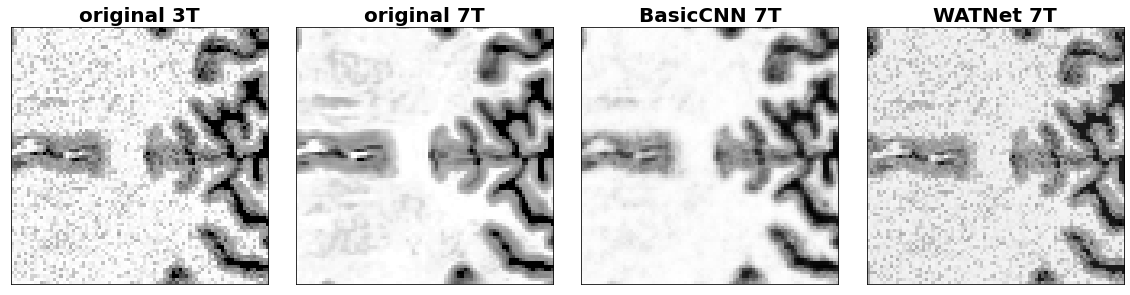

In [52]:
# zoom on some patches 

filename_0 = list_3T[1]

img_3T_0 = nib.load(os.path.join(f_3T_name, filename_0)).get_fdata()
img_7T_0 = nib.load(os.path.join(f_7T_name, filename_0)).get_fdata()

img_7T_synth_advanced_0 = np.load(os.path.join(f_7T_synth_cnn_advanced, filename_0+'.npz'))['x']
img_7T_synth_basic_0= np.load(os.path.join(f_7T_synth_cnn_basic, filename_0+'.npz'))['x']


fig, axes = plt.subplots(1, 4, figsize=(4*4, 4))
axes[0].imshow(img_3T_0[50:60+70, 90:90+80, 100], cmap='gray')
axes[1].imshow(img_7T_0[50:60+70, 90:90+80, 100], cmap='gray')
axes[2].imshow(img_7T_synth_basic_0[50:60+70, 90:90+80, 100], cmap='gray')
axes[3].imshow(img_7T_synth_advanced_0[50:60+70, 90:90+80, 100], cmap='gray')

axes[0].set_title('original 3T', fontweight="bold", size=20)
axes[1].set_title('original 7T', fontweight="bold", size=20)
axes[2].set_title('BasicCNN 7T', fontweight="bold", size=20)
axes[3].set_title('WATNet 7T', fontweight="bold", size=20)


axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[3].set_xticks([])
axes[3].set_yticks([])

plt.tight_layout()
